В этой тетрадке я напишу свои мысли по поводу фильтрации

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import preprocessor as prep
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from sklearn.preprocessing import MinMaxScaler

Вот так выглядит двумерное распределение дебита от времени измерения. Но время замера протянуто впереёд, полную картину дадут исходные данные

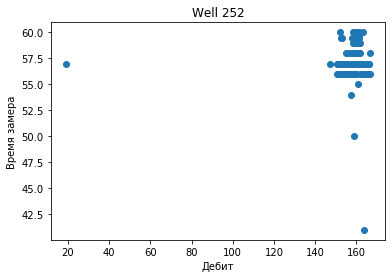

143


In [45]:
wells = [252, 658, 693, 1354, 1479, 1509]
well = 252
calculated_data = prep.load_calculated_data_from_csv(f'data/{well}/restore_/{well}_restore_1.csv')
input_data = pd.read_csv(f'data/{well}/restore_input_/{well}_restore_input.csv',
                         parse_dates=True, index_col = 'Время')
all_data = input_data.join(calculated_data, how = 'outer')
all_data.to_csv(f'data/{well}/restore_/{well}_calc_and_input.csv')

plt.scatter(all_data['Объемный дебит жидкости (СУ)'], all_data['Время замера фактическое (СУ)'])
plt.xlabel('Дебит')
plt.ylabel('Время замера')
plt.title(f'Well {well}')
plt.show()
print(len(all_data['Объемный дебит жидкости (СУ)']))

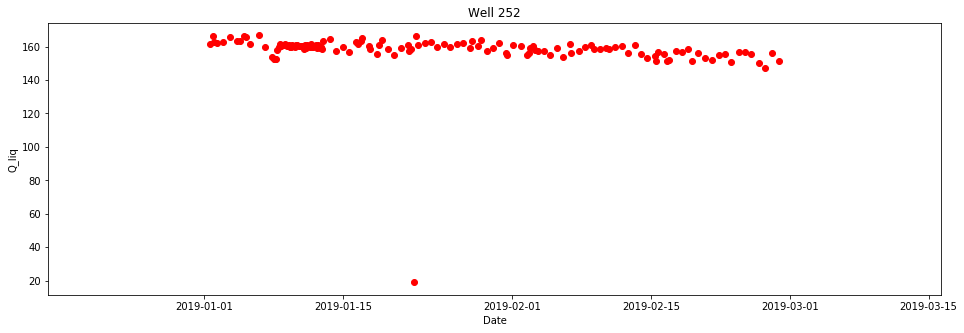

In [46]:
pfig = plt.figure(figsize=(16,5))
plt.scatter(all_data['Объемный дебит жидкости (СУ)'].index,
            all_data['Объемный дебит жидкости (СУ)'].values.reshape((-1, 1)), c='red',
            label='not filtered_data')
plt.xlabel('Date')
plt.ylabel('Q_liq')
plt.title(f'Well {well}')
plt.show()

А вот так выглядят настоящие данные

In [13]:
cs_d = pd.read_csv(f'data/{well}/init_edit/{well}_first_edit.csv')

In [61]:
type(cs_d.dropna(subset=['Объемный дебит жидкости'])['Время'])

pandas.core.series.Series

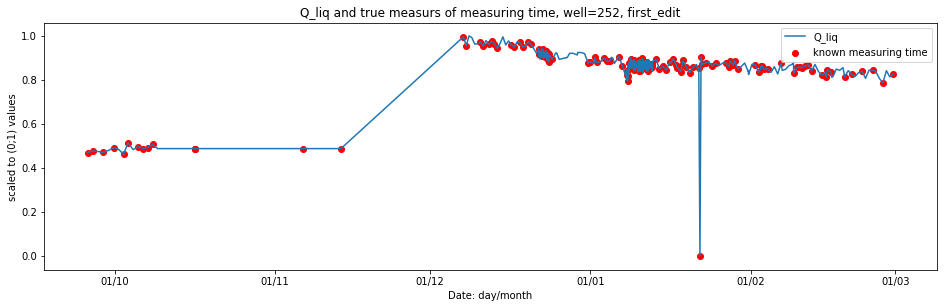

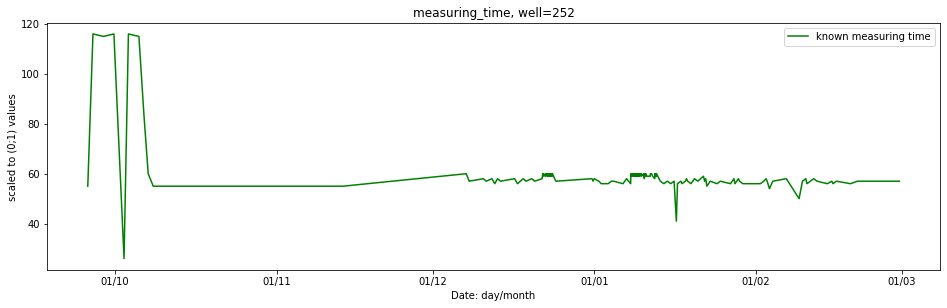

Известно замеров: 46.3768115942029%


In [63]:


sc = MinMaxScaler()
# строим дебит
fig = plt.figure(figsize=(16,10))
ax =plt.subplot(2, 1, 1)
ax.plot(pd.to_datetime(cs_d.dropna(subset=['Объемный дебит жидкости'])['Время']),
         sc.fit_transform(cs_d['Объемный дебит жидкости'].dropna().values.reshape((-1, 1))),
           label='Q_liq')

sc_data  = cs_d[['Время замера фактическое', 'Время']].dropna().join(cs_d['Объемный дебит жидкости'].dropna().to_frame(),
                                                                     how='inner')
# строим флажки там где известно время замера
ax.scatter(pd.to_datetime(sc_data.dropna(subset=['Объемный дебит жидкости'])['Время']),
           sc.transform(sc_data['Объемный дебит жидкости'].dropna().values.reshape((-1, 1))), c='red',
           label='known measuring time')

ax.set(xlabel='Date: day/month', ylabel='scaled to (0;1) values',
       title=f'Q_liq and true measurs of measuring time, well={well}, first_edit'
      )
plt.legend(loc='upper right')
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))
plt.show()


fig = plt.figure(figsize=(16,10))           
ax =plt.subplot(2, 1, 2)
ax.plot(pd.to_datetime(sc_data.dropna(subset=['Объемный дебит жидкости'])['Время'].values),
            sc_data['Время замера фактическое'].dropna().values.reshape((-1, 1)), c='green',
            label='known measuring time')
ax.set(xlabel='Date: day/month', ylabel='scaled to (0;1) values',
           title=f'measuring_time, well={well}')
plt.legend(loc='upper right')
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))
plt.show()

known_part = sc_data["Объемный дебит жидкости"].dropna().shape[0]/cs_d["Объемный дебит жидкости"].dropna().shape[0]
print(f'Известно замеров: {known_part*100}%')

Видно, что замеры в области пика не производились, это наводит на мысль, что делать выводы о некорректности замеров только лишь по времени замера - некорректно, из-за отсутствия адекватного набора данных

Будем определять аномалии как отклонение от среднего

In [17]:
m = all_data['Объемный дебит жидкости (СУ)'].mean()
sigma =  all_data['Объемный дебит жидкости (СУ)'].values.std()

In [18]:
all_data_f = all_data.copy()
all_data_f = all_data_f[all_data_f['Объемный дебит жидкости (СУ)'] <= m + 3 * sigma]
all_data_f = all_data_f[all_data_f['Объемный дебит жидкости (СУ)'] >= m - 2 * sigma]

Ещё мы наверняка знаем, что бывают плохие замеры

In [66]:
all_data_f.columns.values

array(['Динамический уровень (СУ)', 'Частота турбинного вращения (СУ)',
       'Процент обводненности (СУ)', 'Массовый дебит нефти (СУ)',
       'Массовый дебит жидкости (СУ)', 'Давление на выкиде насоса (СУ)',
       'Расход жидкости (СУ)', 'Плотность жидкости (СУ)',
       'Температура на выкиде насоса (СУ)', 'Объемный дебит газа (СУ)',
       'Объемный дебит нефти (СУ)', 'Объемный дебит жидкости (СУ)',
       'Объемный дебит воды (СУ)',
       'Активная энергия (прямая) за весь период (СУ)',
       'Активная мощность (СУ)', 'Общее количество запусков насоса (СУ)',
       'Количество качаний в минуту (СУ)',
       'Активная энергия (обратная) за весь период (СУ)',
       'Реактивная энергия (обратная) за весь период (СУ)',
       'Выходная частота ПЧ (СУ)', 'Ток фазы А (СУ)', 'Ток фазы В (СУ)',
       'Ток фазы С (СУ)', 'Дисбаланс токов (СУ)',
       'Ток в звене постоянного тока (СУ)',
       'Дисбаланс тока полуходовой (СУ)', 'Коэффициент мощности (СУ)',
       'Нагрузка на шток ма

In [67]:
all_data_f = all_data_f[all_data_f['Время замера фактическое (СУ)'] <  all_data_f['Время замера плановое (СУ)'] + 15]

Построим результаты фильтрации

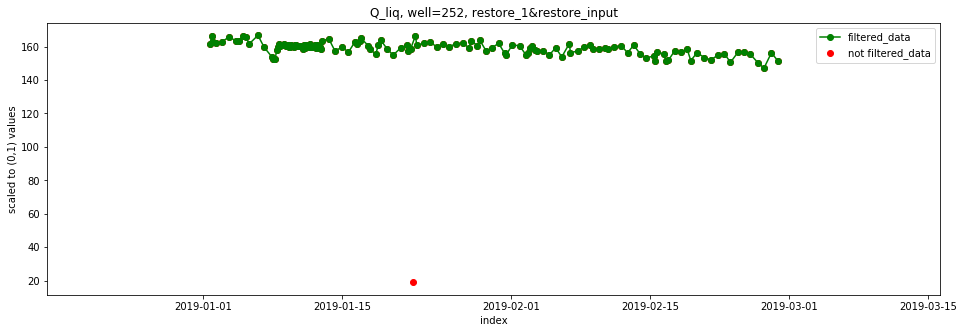

In [73]:
pfig = plt.figure(figsize=(16,5))
plt.scatter(all_data['Объемный дебит жидкости (СУ)'].dropna().index,
            all_data['Объемный дебит жидкости (СУ)'].dropna().values.reshape((-1, 1)), c='red',
            label='not filtered_data')
plt.plot(all_data_f['Объемный дебит жидкости (СУ)'].dropna().index,
            all_data_f['Объемный дебит жидкости (СУ)'].dropna().values.reshape((-1, 1)), '-o', c='green',
            label='filtered_data')
plt.title(f'Q_liq, well={well}, restore_1&restore_input')
plt.ylabel('scaled to (0,1) values')
plt.xlabel('index')
plt.legend(loc='upper right')
plt.show()